# Introduction

**Authors: M. Ravasi, D. Vargas, I. Vasconcelos**

Welcome to the **Solving large-scale inverse problems in Python with PyLops** tutorial!

The aim of this tutorial is to:

- introduce you to the concept of *linear operators* and their usage in the solution of *inverse problems*;
- show how PyLops can be used to set-up non-trivial linear operators and solve inverse problems in Python; 
- Walk you through a set of use cases where PyLops has been leveraged to solve real scientific problems and present future directions of development.

## Useful links

- Tutorial Github repository: https://github.com/mrava87/pylops_pydata2020
        
- PyLops Github repository: https://github.com/equinor/pylops

- PyLops reference documentation: https://pylops.readthedocs.io/en/latest/

## Theory in a nutshell

In this tutorial we will try to keep the theory to a minimum and quickly expose you to practical examples. However, we want to make sure that some of the basic underlying concepts are clear to everyone and define a common mathematical notation.

At the core of PyLops lies the concept of **linear operators**. A linear operator is generally a mapping or function that acts linearly on elements of a space to produce elements of another space. More specifically we say that $\mathbf{A}:\mathbb{F}^m \to \mathbb{F}^n$ is a linear operator that maps a vector of size $m$ in the *model space* to a vector of size $n$ in the *data space*:

$$\mathbf{y} =  \mathbf{A} \mathbf{x}$$

We will refer to this as **forward model (or operation)**. 

Conversely the application of its adjoint to a data vector is referred to as **adjoint modelling (or operation)**:

$$\mathbf{x} = \mathbf{A}^H \mathbf{y}$$

In its simplest form, a linear operator can be seen as a **matrix** of size $n \times m$ (and the adjoint is simply its transpose and complex conjugate). However in a more general sense we can think of a linear operator is any pair of software code that mimics the effect a matrix on a model vector as well as that of its adjoint to a data vector.

Solving an inverse problems accounts to removing the effect of the operator/matrix $\mathbf{A}$ from the data $\mathbf{y}$ to retrieve the model $\mathbf{x}$ (or an approximation of it).

$$\hat{\mathbf{x}} = \mathbf{A}^{-1} \mathbf{y}$$

In practice, the inverse of $\mathbf{A}$ is generally not explicitely required. A solution can be obtained using either direct methods, matrix decompositions (eg SVD) or iterative solvers. Luckily, many iterative methods (e.g. cg, lsqr) do not need to know the individual entries of a matrix to solve a linear system. Such solvers only require the computation of forward and adjoint matrix-vector products - exactly what a linear operator does!

**So what?**
We have learned that to solve an inverse problem, we do not need to express the modelling operator in terms of its dense (or sparse) matrix. All we need to know its how to perform the forward and adjoint operations - ideally as fast as possible and using the least amount of memory. 

Our first task will be to understand how we can effectively write a linear operator on pen and paper and translate it into computer code. We will consider 2 examples:

- Element-wise multiplication (also known as Hadamard product)
- First Derivative

Let's first import the libraries we need in this tutorial

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylops
import scooby

from scipy.linalg import lstsq
from pylops import LinearOperator
from pylops.utils import dottest

## Element-wise multiplication

We start by creating a barebore linear operator that performs a simple element-wise multiplication between two vectors (the so-called Hadamart product):

$$ y_i = d_i x_i  \quad \forall i=0,1,...,n-1 $$

If we think about the forward problem the way we wrote it before, we can see that this operator can be equivalently expressed as a dot product multiplucation between a square matrix $\mathbf{D}$ that has the $d_i$ elements along its main diagonal and a vector $\mathbf{x}$:

$$ 
\begin{bmatrix}
    y_0  \\
    y_1  \\
    ...  \\
    y_{n-1}
\end{bmatrix} = 
\begin{bmatrix}
    d_0 & 0 & 0 & ... & 0\\
    0 & d_1 & 0 & ... & 0\\
    ... & ... & ... & ... & ...\\
    0 & 0   & 0 & ... & d_{n-1}
\end{bmatrix} 
\begin{bmatrix}
    x_0  \\
    x_1  \\
    ...     \\
    x_{n-1}
\end{bmatrix}
$$

Because of this, the related linear operator is called *Diagonal* operator in PyLops.

We are ready to implement this operator in 2 different ways:

- directly as a diagonal matrix diagonal matrix or a 
- as a linear operator that performs directly element-wise multiplication

### Dense matrix definition

In [2]:
n = 10
diag = np.arange(n)

D = np.diag(diag)
print('D:\n', D)

D:
 [[0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 6 0 0 0]
 [0 0 0 0 0 0 0 7 0 0]
 [0 0 0 0 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 0 0 9]]


We can now apply the forward by simply using `np.dot`

In [3]:
x = np.ones(n)
y = np.dot(D, x) # or D.dot(x) or D @ x
print('y: ', y)

y:  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


As we have access to all the entries of the matrix, it is very easy to write the adjoint

In [4]:
xadj = np.dot(np.conj(D.T), y)
print('xadj: ', xadj)

xadj:  [ 0.  1.  4.  9. 16. 25. 36. 49. 64. 81.]


*Note:* since the elements of our matrix are real numbers, we can avoid applying the complex conjugation here.

Everything seems very easy so far. This approach does however carry some problems:
    
- we are storing $N^2$ numbers, even though we know that are matrix has only elements along its diagonal.
- we are applying a dot product which requires $N^2$ multiplications and summations (most of them with zeros

Of course in this case we could use a sparse matrix, which allows to store only non-zero elements (and their index) and provides a faster way to perform the dot product.

### Linear operator definition

Let's take a leap of faith, and see if we can avoid thinking about the matrix altogether and write just an equivalent (ideally faster) piece of code that mimics this operation.

To write its equivalent linear operator, we define a class with an init method, and 2 other methods:
    
- _matvec: we write the forward operation here
- _rmatvec: we write the adjoint operation here
    
We are subclassing PyLops LinearOperator, for the moment let's not get into the details of what that entails and simply focus on writing the content of these two methods.

**EX:** try writing the operator

**SOLUTION**

In [5]:
%load -s Diagonal solutions/intro_sol.py

Now we create the operator

In [6]:
Dop = Diagonal(diag)
print('Dop: ', Dop)

Dop:  <10x10 Diagonal with dtype=float64>


### Linear operator application

Forward

In [7]:
y = Dop * x
print('y: ', y)

y:  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


Adjoint

In [8]:
xadj = Dop.H * y
print('xadj: ', xadj)

xadj:  [ 0.  1.  4.  9. 16. 25. 36. 49. 64. 81.]


As expected we obtain the same results!

**EX:** try making a much bigger vector $\mathbf{d}$ and time the forward and adjoint for the two approaches

In [ ]:
%load -s Diagonal_timing solutions/intro_sol.py

### Linear operator testing

One of the most important aspect of writing a Linear operator is to be able to verify that the code implemented in forward mode and the code implemented in adjoint mode are effectively adjoint to each other. 

If this is not the case, we will struggle to invert our linear operator - some iterative solvers will diverge and other show very slow convergence.

This is instead the case if the so-called *dot-test* is passed within a certain treshold:

$$
(\mathbf{A}*\mathbf{u})^H*\mathbf{v} = \mathbf{u}^H*(\mathbf{A}^H*\mathbf{v})
$$

where $\mathbf{u}$ and $\mathbf{v}$ are two random vectors.

Let's use `pylops.utils.dottest`

In [11]:
dottest(Dop, n, n, verb=True);

Dot test passed, v^T(Opu)=-6.134688 - u^T(Op^Tv)=-6.134688


## First Derivative

Let's consider now something less trivial. We take a first order centered first derivative:

$$ y_i = \frac{x_{i+1} - x_{i-1}}{\Delta}  \quad \forall i=1,2,...,N $$

where $\Delta$ is the sampling step of the input signal. Note that we will deal differently with the edges, using a forward/backward derivative.

### Dense matrix definition

In [12]:
nx = 11

D = np.diag(0.5*np.ones(nx-1),k=1) - np.diag(0.5*np.ones(nx-1),-1) 
D[0, 0] = D[-1, -2] = -1
D[0, 1] = D[-1, -1] = 1
print('D:\n', D)

D:
 [[-1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [-0.5  0.   0.5  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -0.5  0.   0.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.   0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -0.5  0.   0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -0.5  0.   0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.5  0.   0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.5  0.   0.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.5  0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -0.5  0.   0.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.  -1.   1. ]]


### Linear operator definition

**EX:** try writing the operator

**SOLUTION**

In [ ]:
%load -s FirstDerivative solutions/intro_sol.py

Define the operator

In [15]:
Dop = FirstDerivative(nx)
print('Dop: ', Dop)

Dop:  <11x11 FirstDerivative with dtype=float64>


Perform the dot test

In [16]:
dottest(Dop, nx, nx, verb=True);

Dot test passed, v^T(Opu)=1.452896 - u^T(Op^Tv)=1.452896


Now that you understand, you can use PyLops implementation of this operator (see https://pylops.readthedocs.io/en/latest/api/generated/pylops.FirstDerivative.html for details)

In [17]:
Dop = pylops.FirstDerivative(nx, edge=True)
print('Dop: ', Dop)

Dop:  <11x11 FirstDerivative with dtype=float64>


In [18]:
dottest(Dop, nx, nx, verb=True);

Dot test passed, v^T(Opu)=2.359775 - u^T(Op^Tv)=2.359775


### Linear operator application

In [20]:
x = np.arange(nx) - (nx-1)/2
print('x: ', x)

x:  [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


Forward

In [21]:
y = np.dot(D, x)
print('y: ', y)

y = Dop * x
print('y: ', y)

y:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
y:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Adjoint

In [22]:
xadj = np.dot(D.T, y)
print('xadj: ', xadj)

xadj = Dop.H * y
print('xadj: ', xadj)

xadj:  [-1.5  0.5  0.   0.   0.   0.   0.   0.   0.  -0.5  1.5]
xadj:  [-1.5  0.5  0.   0.   0.   0.   0.   0.   0.  -0.5  1.5]


**EX:** Same as before, let's time our two implementations

In [ ]:
%load -s FirstDerivative_timing solutions/intro_sol.py

**EX:** try to compare the memory footprint of the matrix $\mathbf{D}$ compared to its equivalent linear operator. Hint: install ``pympler`` and use ``pympler.asizeof``

In [ ]:
%load -s FirstDerivative_memory solutions/intro_sol.py

Finally, let's try to move on step further and try to solve the inverse problem. 

For the dense matrix, we will use `scipy.linalg.lstsq`. For operator PyLops this can be very easily done by using the '/' which will call `scipy.sparse.linalg.lsqr` solver (you can also use this solver directly if you want to fine tune some of its input parameters

In [26]:
xinv = lstsq(D, y)[0]
print('xinv: ', xinv)

xinv = Dop / y
print('xinv: ', xinv)

xinv:  [-5.00000000e+00 -4.00000000e+00 -3.00000000e+00 -2.00000000e+00
 -1.00000000e+00  6.96836792e-16  1.00000000e+00  2.00000000e+00
  3.00000000e+00  4.00000000e+00  5.00000000e+00]
xinv:  [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


In both cases we have retrieved the correct solution!

## Chaining operators

Up until now, we have discussed how brand new operators can be created in few systematic steps. This sounds cool, but it may look like we would need to do this every time we need to solve a new problem.

This is where **PyLops** comes in. Alongside providing users with an extensive collection of operators, the library allows such operators to be combined via basic algebraic operations (eg summed, subtracted, multiplied) or chained together (vertical and horizontal stacking, block and block diagonal).

We will see more of this in the following. For now let's imagine to have a modelling operator that is a smooth first-order derivative. To do so we can chain the ``FirstDerivative`` operator ($\mathbf{D}$) that we have just created with a smoothing operator ($\mathbf{S}$)(https://pylops.readthedocs.io/en/latest/api/generated/pylops.Smoothing1D.html#pylops.Smoothing1D) and write the following problem:

$$\mathbf{y} = \mathbf{S} \mathbf{D} \mathbf{x}$$

Let's create it first and attempt to invert it afterwards.

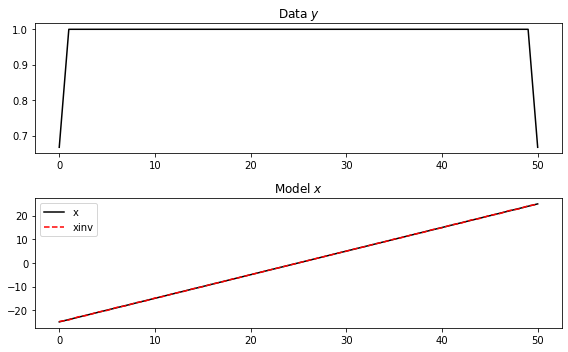

In [27]:
nx = 51
x = np.arange(nx) - (nx-1)/2

Dop = pylops.FirstDerivative(nx, edge=True)
Sop = pylops.Smoothing1D(3, nx)

# Chain the two operators
Op = Sop * Dop

# Create data
y = Op * x

# Invert
xinv = Dop / y

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))
ax1.plot(y, 'k')
ax1.set_title(r"Data $y$")
ax2.plot(x, 'k', label='x')
ax2.plot(xinv, '--r', label='xinv')
ax2.legend()
ax2.set_title(r"Model $x$")
plt.tight_layout()

## Recap

In this first tutorial we have learned to:

- translate a linear operator from pen and paper to computer code
- write our own linear operators
- use PyLops linear operators to perform forward, adjoint and inverse
- combine PyLops linear operators.

In [28]:
scooby.Report(core='pylops')

--------------------------------------------------------------------------------
  Date: Sun Sep 06 08:53:33 2020 CEST

            Darwin : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
            8.0 GB : RAM
           Jupyter : Environment

  Python 3.7.2 (default, Dec 29 2018, 00:00:04)  [Clang 4.0.1
  (tags/RELEASE_401/final)]

1.7.1.dev32+g712d179.d20200111 : pylops
            1.18.1 : numpy
             1.5.0 : scipy
             7.2.0 : IPython
             3.3.1 : matplotlib
             0.4.1 : scooby

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------